In [1]:
import glob
import os
import pickle
import time
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from scripts.gifMaker import make_gif_from_array
from src.common import as_intrinsics_matrix
from torch.utils.data import Dataset
import threading
from tqdm import tqdm
from src.utils.datasets import get_dataset
import time

import torch.multiprocessing as mp
from src.utils import backproject, create_instance_seg, id_generation, vis
import argparse
from src.NICE_SLAM import NICE_SLAM
from src import config
import seaborn as sns

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
parser = argparse.ArgumentParser(
description="Arguments for running the NICE-SLAM/iMAP*."
)
parser.add_argument("config", type=str, help="Path to config file.")
parser.add_argument(
    "--input_folder",
    type=str,
    help="input folder, this have higher priority, can overwrite the one in config file",
)
parser.add_argument(
    "--output",
    type=str,
    help="output folder, this have higher priority, can overwrite the one in config file",
)
nice_parser = parser.add_mutually_exclusive_group(required=False)
nice_parser.add_argument("--nice", dest="nice", action="store_true")
nice_parser.add_argument("--imap", dest="nice", action="store_false")
parser.set_defaults(nice=True)
args = parser.parse_args(args=['/home/rozenberszki/project/wsnsl/configs/Own/room0_panoptic.yaml'])
#args = parser.parse_args(args=['/home/rozenberszki/project/wsnsl/configs/Own/room0.yaml'])

cfg = config.load_config(  # J:changed it to use our config file including semantics
        args.config, "configs/nice_slam_sem.yaml" if args.nice else "configs/imap.yaml"
    )
slam = NICE_SLAM(cfg, args)
frame_reader = get_dataset(cfg, args, cfg["scale"], slam = slam)
frame_reader.__post_init__(slam)
zero_pos = frame_reader.poses[0]
zero_pos

['Datasets/Replica/room0_panoptic/results/frame_00000.png', 'Datasets/Replica/room0_panoptic/results/frame_00001.png', 'Datasets/Replica/room0_panoptic/results/frame_00002.png', 'Datasets/Replica/room0_panoptic/results/frame_00003.png', 'Datasets/Replica/room0_panoptic/results/frame_00004.png', 'Datasets/Replica/room0_panoptic/results/frame_00005.png', 'Datasets/Replica/room0_panoptic/results/frame_00006.png', 'Datasets/Replica/room0_panoptic/results/frame_00007.png', 'Datasets/Replica/room0_panoptic/results/frame_00008.png', 'Datasets/Replica/room0_panoptic/results/frame_00009.png', 'Datasets/Replica/room0_panoptic/results/frame_00010.png', 'Datasets/Replica/room0_panoptic/results/frame_00011.png', 'Datasets/Replica/room0_panoptic/results/frame_00012.png', 'Datasets/Replica/room0_panoptic/results/frame_00013.png', 'Datasets/Replica/room0_panoptic/results/frame_00014.png', 'Datasets/Replica/room0_panoptic/results/frame_00015.png', 'Datasets/Replica/room0_panoptic/results/frame_00016.pn

tensor([[-0.3837, -0.0573, -0.9217,  1.8172],
        [-0.9234,  0.0238,  0.3830,  2.1154],
        [-0.0000,  0.9981, -0.0621, -0.4463],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])

In [3]:
class Segmenter(object):

    def __init__(self, slam, cfg, args, zero_pos, store_directory):
        self.store_directory = store_directory
        self.zero_pos = zero_pos
        os.makedirs(f"{store_directory}", exist_ok=True)

        s = torch.ones((4, 4)).int()
        if cfg["dataset"] == "tumrgbd":
            #s[[0, 0, 1, 2], [0, 1, 2, 2]] *= -1
            s[[0, 0, 1, 1, 2], [1, 2, 0, 3, 3]] *= -1
        if cfg["dataset"] == "replica" or cfg["dataset"] == 'panoptic':
            print('shift')
            s[[0, 0, 1, 1, 2], [1, 2, 0, 3, 3]] *= -1
        self.shift = s.numpy()  # s
        self.is_full_slam = cfg["Segmenter"]["full_slam"]
        self.store_vis = cfg["Segmenter"]["store_vis"]
        self.use_stored = cfg["Segmenter"]["use_stored"]
        self.first_min_area = cfg["mapping"]["first_min_area"]

        """path_to_traj = cfg["data"]["input_folder"] + "/traj.txt"
        self.T_wc = np.loadtxt(path_to_traj).reshape(-1, 4, 4)
        self.T_wc[:, 1:3] *= -1"""

        self.every_frame = cfg["mapping"]["every_frame"]
        # self.slam = slam
        self.id_counter = slam.id_counter
        self.idx_mapper = slam.mapping_idx
        #self.estimate_c2w_list = slam.estimate_c2w_list
        #self.idx_coarse_mapper = slam.idx_coarse_mapper

        self.every_frame_seg = cfg["Segmenter"]["every_frame"]
        self.points_per_instance = cfg["mapping"]["points_per_instance"]
        '''self.H, self.W, self.fx, self.fy, self.cx, self.cy = (
            slam.H, slam.W, slam.fx, slam.fy, slam.cx, slam.cy
        )'''
        self.H, self.W, self.fx, self.fy, self.cx, self.cy = (
            cfg["cam"]["H"],
            cfg["cam"]["W"],
            cfg["cam"]["fx"],
            cfg["cam"]["fy"],
            cfg["cam"]["cx"],
            cfg["cam"]["cy"],
        )
        self.cfg = cfg
        self.update_cam()
        self.K = as_intrinsics_matrix([self.fx, self.fy, self.cx, self.cy])
        
        if args is None or args.input_folder is None:
            self.input_folder = cfg["data"]["input_folder"]
        else:
            self.input_folder = args.input_folder
        #self.color_paths = sorted(glob.glob(f"{self.input_folder}/results/frame*.jpg"))
        # self.depth_paths = sorted(glob.glob(f"{self.input_folder}/results/depth*.png"))
        self.frame_reader = get_dataset(
            cfg,
            args,
            cfg["scale"],
            device=cfg["mapping"]["device"],
            tracker=False,
            slam=slam,
        )
        self.estimate_c2w_list = np.concatenate([p[None] for p in self.frame_reader.poses], axis=0)
        """for i in range(len(self.estimate_c2w_list)):
            self.estimate_c2w_list[i, :3,:3] = self.estimate_c2w_list[i, :3,:3].T 
            self.estimate_c2w_list[i, :3, 3] = np.matmul(-self.estimate_c2w_list[i, :3,:3], self.estimate_c2w_list[i, :3, 3])
        print(self.estimate_c2w_list.shape)"""
        print(self.estimate_c2w_list.shape)
        print(f'est list: {self.estimate_c2w_list[0]}')
        self.n_img = self.frame_reader.n_img
        self.semantic_frames = slam.semantic_frames
        self.idx_segmenter = slam.idx_segmenter
        if not self.is_full_slam:
            self.idx = torch.tensor([self.n_img])
        else:
            self.idx = slam.idx  # Tracking index
            # Segmenter index
        # self.new_id = 0
        self.visualizer = vis.visualizerForIds()
        self.frame_numbers = []
        self.samples = None
        self.deleted = {}
        self.border = 0 
        '''(
            cfg["cam"]["crop_edge"]
            if "crop_edge" in cfg["cam"]
            else cfg["Segmenter"]["border"]
        )'''
        self.num_clusters = cfg["Segmenter"]["num_clusters"]
        self.overlap = cfg["Segmenter"]["overlap"]
        self.relevant = cfg["Segmenter"]["relevant"]
        self.max_id = 0
        self.update = {}
        self.verbose = cfg["Segmenter"]["verbose"]
        self.merging_parameter = cfg["Segmenter"]["merging_parameter"]
        self.hit_percent = cfg["Segmenter"]["hit_percent"]

    def update_cam(self):
        """
        Update the camera intrinsics according to pre-processing config,
        such as resize or edge crop.
        """
        # resize the input images to crop_size (variable name used in lietorch)
        if "crop_size" in self.cfg["cam"]:
            crop_size = self.cfg["cam"]["crop_size"]
            sx = crop_size[1] / self.W
            sy = crop_size[0] / self.H
            self.fx = sx * self.fx
            self.fy = sy * self.fy
            self.cx = sx * self.cx
            self.cy = sy * self.cy
            self.W = crop_size[1]
            self.H = crop_size[0]

        # croping will change H, W, cx, cy, so need to change here
        if self.cfg["cam"]["crop_edge"] > 0:
            self.H -= self.cfg["cam"]["crop_edge"] * 2
            self.W -= self.cfg["cam"]["crop_edge"] * 2
            self.cx -= self.cfg["cam"]["crop_edge"]
            self.cy -= self.cfg["cam"]["crop_edge"]

    def segment_idx_forAuto(self, idx):
        """img = cv2.imread(self.color_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)"""
        img, depth = self.frame_reader.get_colorAndDepth(idx)
        #gt_color_np = np.clip(img.cpu().numpy(), 0, 1)
        """plt.imshow(gt_color_np)
        plt.title(f'color {idx}')
        plt.show()"""
        img = (img.cpu().numpy() * 255).astype(np.uint8)
        masksCreated, s, max_id = id_generation.createFrontMappingAutosort(
            idx,
            self.estimate_c2w_list*self.shift,
            self.K,
            depth.cpu(),
            self.predictor,
            max_id=self.max_id,
            current_frame=img,
            samples=self.samples,
            smallesMaskSize=1000,
            border=self.border
        )
        #s[2] *= -1
        self.samples = s
        self.max_id = max_id

        frame = torch.from_numpy(masksCreated)
        self.semantic_frames[idx // self.every_frame_seg] = frame
        return frame

    def segment_first_ForAuto(self):
        """color_path = self.color_paths[0]
        color_data = cv2.imread(color_path)
        image = cv2.cvtColor(color_data, cv2.COLOR_BGR2RGB)"""
        image, depth = self.frame_reader.get_colorAndDepth(0)
        sns.histplot(depth.cpu().numpy().reshape(-1), bins=100)
        plt.title('depth 0')
        plt.show()
        image = (image.cpu().numpy() * 255).astype(np.uint8)
        sam = create_instance_seg.create_sam_forauto("cuda")
        masks = sam.generate(image)
        del sam
        torch.cuda.empty_cache()

        ids = backproject.generateIds_Auto(masks,depth.cpu(), min_area=self.first_min_area)
        # visualizerForId = vis.visualizerForIds()
        # visualizerForId.visualize(ids, f'{self.store_directory}/first_segmentation.png')
        ids[depth.cpu() == 0] = -100
        self.semantic_frames[0] = torch.from_numpy(ids)
        self.frame_numbers.append(0)
        self.max_id = ids.max() + 1
        
        samplesFromCurrent = backproject.sample_from_instances_with_ids_area(
            ids, self.max_id, points_per_instance=500
        )
        realWorldSamples = backproject.realWorldProject(
            samplesFromCurrent[:2, :],
            self.zero_pos*self.shift,
            self.K,
            depth.cpu(),
        )
        realWorldSamples = np.concatenate(
            (realWorldSamples, samplesFromCurrent[2:, :]), axis=0
        )
        return realWorldSamples

    def runAuto(self, max=-1):
        visualizerForId = vis.visualizerForIds()

        print("segment first frame")
        s = self.segment_first_ForAuto()
        #print("finished segmenting first frame")
        visualizerForId.visualize(self.semantic_frames[0], path = 'test/00_after.png')
        im = visualizerForId.visualize(self.semantic_frames[0])
        plt.show()
        if self.is_full_slam:
            path = os.path.join(self.store_directory, f"seg_{0}.npy")
            # np.save(path, self.semantic_frames[0].numpy())
            self.idx_segmenter[0] = 0
        #s[2] *= -1
        self.samples = s
        #self.samples = np.array([[0,0,1],[0,1,0],[1,0,0], [0,0,0]])
        print(np.unique(self.samples[3], return_counts=True))
        self.predictor = create_instance_seg.create_sam_forauto("cuda")
   
        index_frames = np.arange(
            self.every_frame_seg, self.n_img, self.every_frame_seg
        )
          
        self.plot()
        for idx in index_frames: #tqdm(index_frames, desc="Segmenting frames"):
            if idx == 200:
                #self.plot_mesh()
                return
            #print("start segmenting frame: ", idx)
            start = time.time()
            self.segment_idx_forAuto(idx)
            print(f'time: {time.time()-start}')
            print(np.unique(self.samples[3], return_counts=True))
            frame = self.semantic_frames[idx // self.every_frame_seg]
            #print("finished segmenting frame: ", idx)
            #fig, ax = plt.subplots(1)

            visualizerForId.visualize(
                frame.cpu().numpy()
            )
            plt.title(f"frame: {idx}")
            #ax[1].imshow(self.frame_reader.get_colorAndDepth(idx)[1].cpu().numpy())
            plt.show()
            self.plot()
            """_,depth= frame_reader.get_colorAndDepth(idx)
            sns.heatmap(depth.cpu().numpy() == 0)
            plt.show()"""
            # print(f'outside samples: {np.unique(self.samples[-1])}')
        if self.n_img - 1 % self.every_frame_seg != 0:
            _ = self.segment_idx_forAuto(self.n_img - 1)


        return self.semantic_frames, self.max_id + 1
    
    def plot_mesh(self):
        import open3d as o3d
        data = self.samples.copy()[:3].T
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(data)
        pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

        # Step 2: Compute a mesh using the Ball Pivoting algorithm
        # You may need to adjust the radii parameter based on the scale of your point cloud
        radii = [1,1,1,1]
        mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
            pcd, o3d.utility.DoubleVector(radii))

        # Step 3: Simplify the mesh (optional, if you need to reduce the complexity)
        mesh_simplified = mesh.simplify_quadric_decimation(target_number_of_triangles=1000)
        o3d.io.write_triangle_mesh("test_mesh.obj", mesh_simplified)

        plt.show()
    
    def plot(self):
        data = self.samples.copy()
        #data = data[:, data[1] > -2]
        data = self.samples.copy()
        #data = data[:, data[1] > -2]
        x = data[0]
        y = data[1]
        z = data[2] * -1
        labels = data[3]

        # Create a scatter plot
        fig = plt.figure()
        fig.set_size_inches(18.5, 10.5)
        ax = fig.add_subplot(111, projection="3d")
        ax = fig.add_subplot(111, projection="3d")

        # Plot each point with a color corresponding to its label
        unique_labels = np.unique(labels)
        for label in unique_labels:
            indices = np.where(labels == label)
            ax.scatter(x[indices], y[indices], z[indices], s=3)

        # Set axis labels
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        #ax.set_ylim((-2, 2))
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        #ax.set_ylim((-2, 2))
        # Add a legend
        ax.legend()

        # Show the plot
        plt.show()
    
    def debugging(self):
        poses = self.estimate_c2w_list
        ff_pos = np.array([[0,1,30,300],[1,0,30,300]])
        print(ff_pos.T)
        depth = frame_reader.get_colorAndDepth(20)[1].cpu()
        ff_rw = backproject.realWorldProject(ff_pos, poses[20], self.K, depth)
        print(ff_rw)
        cam = backproject.camProject(ff_rw, poses[20], self.K)[0].T
        print(cam)
        """rw_pos = np.array([[100,0,0],[0,0,100],[0,100,0]])
        poses = self.estimate_c2w_list
        print(ff_pos)
        
        plt.imshow(depth)
        plt.show()
        ff_rw = backproject.realWorldProject(ff_pos, poses[0], self.K, depth)
        print(ff_rw)
        cam = backproject.camProject(rw_pos, poses[20], self.K)[0].T
        print(cam)
        plt.scatter(cam[:,0], cam[:,1])
        plt.show()"""

In [4]:
frame_reader.get_colorAndDepth(0)[1]

tensor([[2.1040, 2.1050, 2.1050,  ..., 2.0750, 2.0760, 2.0760],
        [2.1120, 2.1120, 2.1130,  ..., 2.0840, 2.0840, 2.0840],
        [2.1180, 2.1200, 2.1210,  ..., 2.0920, 2.0920, 2.0930],
        ...,
        [0.5720, 0.5730, 0.5730,  ..., 1.5330, 1.5330, 1.5330],
        [0.5710, 0.5720, 0.5720,  ..., 1.5270, 1.5270, 1.5260],
        [0.5700, 0.5700, 0.5710,  ..., 1.5210, 1.5210, 1.5200]],
       device='cuda:0')

In [5]:
segmenter = Segmenter(slam, cfg, args, zero_pos, 'test')

shift
['Datasets/Replica/room0_panoptic/results/frame_00000.png', 'Datasets/Replica/room0_panoptic/results/frame_00001.png', 'Datasets/Replica/room0_panoptic/results/frame_00002.png', 'Datasets/Replica/room0_panoptic/results/frame_00003.png', 'Datasets/Replica/room0_panoptic/results/frame_00004.png', 'Datasets/Replica/room0_panoptic/results/frame_00005.png', 'Datasets/Replica/room0_panoptic/results/frame_00006.png', 'Datasets/Replica/room0_panoptic/results/frame_00007.png', 'Datasets/Replica/room0_panoptic/results/frame_00008.png', 'Datasets/Replica/room0_panoptic/results/frame_00009.png', 'Datasets/Replica/room0_panoptic/results/frame_00010.png', 'Datasets/Replica/room0_panoptic/results/frame_00011.png', 'Datasets/Replica/room0_panoptic/results/frame_00012.png', 'Datasets/Replica/room0_panoptic/results/frame_00013.png', 'Datasets/Replica/room0_panoptic/results/frame_00014.png', 'Datasets/Replica/room0_panoptic/results/frame_00015.png', 'Datasets/Replica/room0_panoptic/results/frame_00

In [6]:
segmenter.debugging()

[[  0   1]
 [  1   0]
 [ 30  30]
 [300 300]]
[[-0.23539419 -0.24066467 -0.56856582 -0.7705131 ]
 [ 5.12808884  5.12528185  5.39257599  2.97394039]
 [-1.79252764 -1.80175572 -1.79531117  0.41093641]]
[[  0   1]
 [  1   0]
 [ 30  30]
 [299 300]]


In [7]:
import os
import shutil

folder_path = '/home/rozenberszki/project/wsnsl/test'

# Check if the folder exists
if os.path.exists(folder_path):
    # Delete the folder and its contents
    shutil.rmtree(folder_path)

# Create the folder
os.makedirs(folder_path)


segment first frame


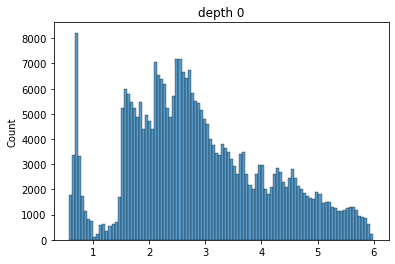

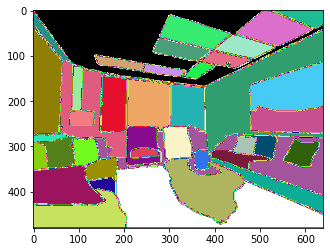

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41.]), array([1762, 1326,  966,   41,  513,  486,  569,  487,  445,  421,  370,
        319,  293,  268,  264,  261,  256,  183,  150,  111,  161,  159,
        151,  126,  116,  107,  106,   96,   86,   85,   81,   76,   70,
         68,   64,   60,   56,   55,   50,   47,   40]))


No handles with labels found to put in legend.


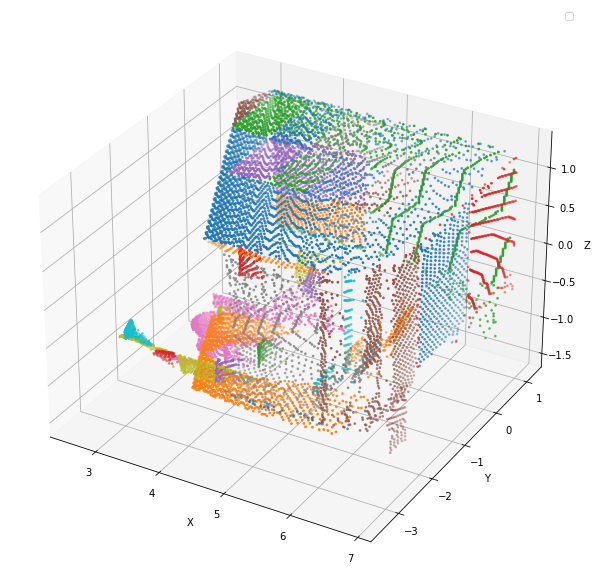

mask generation time:  0.7980468273162842
time: 0.9375286102294922
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47.]), array([3208, 3289, 1924,   83, 1195,  954,  971,  928, 1088,  770,  729,
        534,  527,  533,  500,  520,  621,  346,  363,  215,  311,  159,
        151,  216,  207,  107,  190,  186,  153,  170,  159,  135,  132,
         68,  117,  118,   56,  108,   50,   87,   93,  247,  126,  101,
         49,   47,   43]))


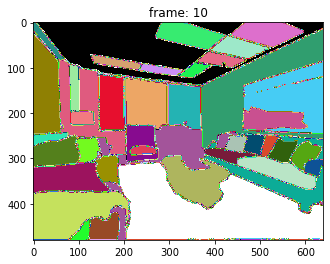

No handles with labels found to put in legend.


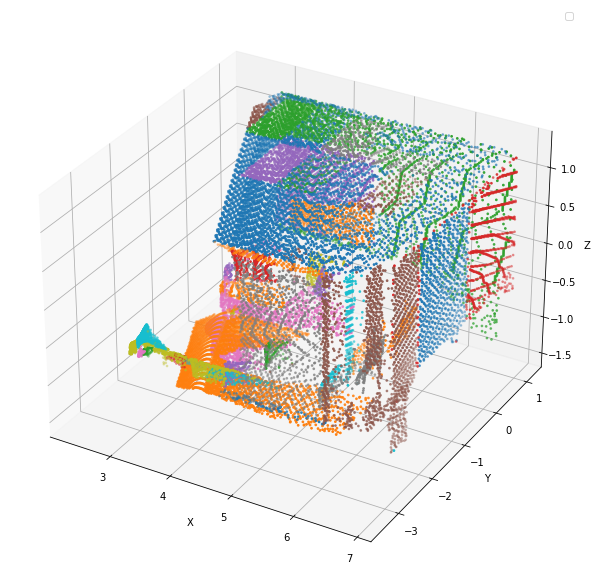

mask generation time:  0.8035693168640137
time: 0.9942061901092529
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]), array([4409, 5381, 2852,   83, 2047, 1423, 1288, 1611, 1814, 1021, 1074,
        534,  690,  804,  698,  749,  914,  522,  593,  314,  456,  246,
        151,  295,  276,  107,  265,  271,  217,  170,  223,  191,  180,
         68,  167,  118,   56,  156,   50,   87,  203,  458,  220,  187,
        197,  107,   43,  118,   88,   57]))


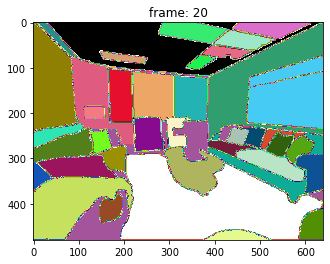

No handles with labels found to put in legend.


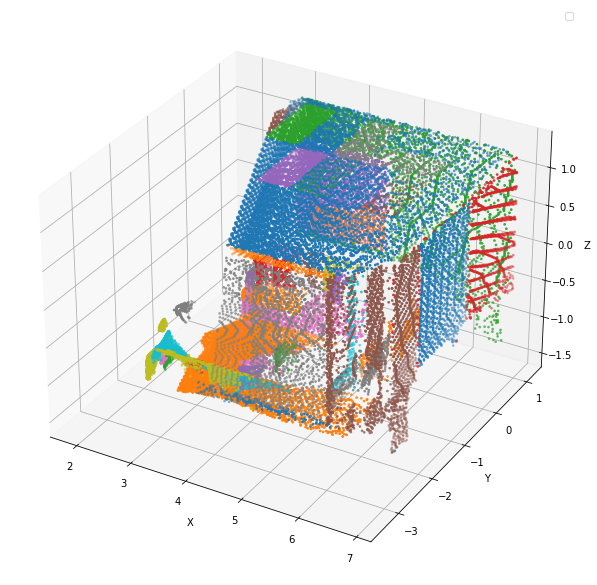

mask generation time:  0.8120429515838623
time: 1.0602490901947021
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53.]), array([5808, 7297, 4214,   83, 2606, 1423, 1560, 2463, 2393, 1178, 1395,
        744,  842, 1080,  879,  944, 1248,  677,  807,  418,  456,  345,
        151,  368,  330,  107,  265,  271,  279,  170,  272,  250,  180,
         68,  216,  118,   56,  201,   50,   87,  371,  659,  282,  266,
        383,  160,   43,  383,  302,  199,  150,  107,   50]))


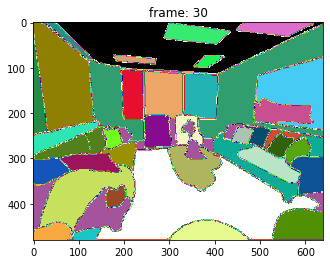

No handles with labels found to put in legend.


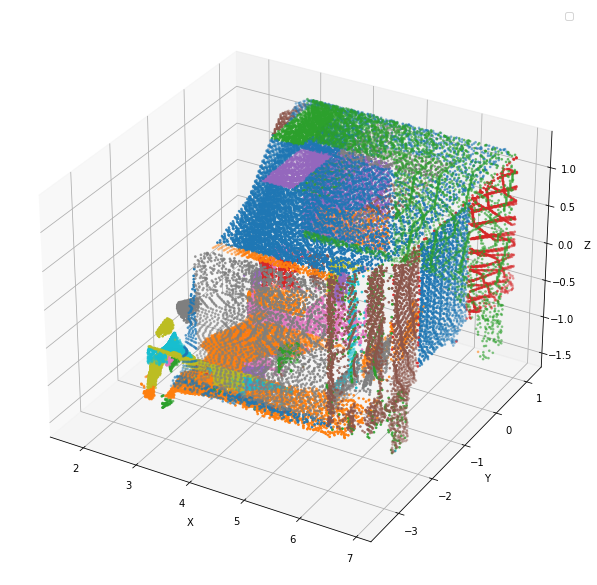

mask generation time:  0.8047401905059814
time: 1.0896036624908447
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54.]), array([7448, 9055, 5396,   83, 3292, 1423, 1806, 3070, 2804, 1290, 1696,
        744, 1067, 1355, 1023, 1111, 1547,  818,  908,  488,  456,  445,
        151,  437,  330,  107,  334,  271,  341,  224,  272,  324,  180,
         68,  265,  118,   56,  201,   50,   87,  584,  849,  329,  342,
        598,  160,   43,  649,  522,  326,  747,  317,   50,   44]))


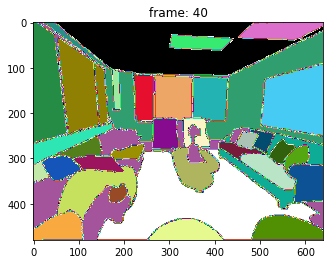

No handles with labels found to put in legend.


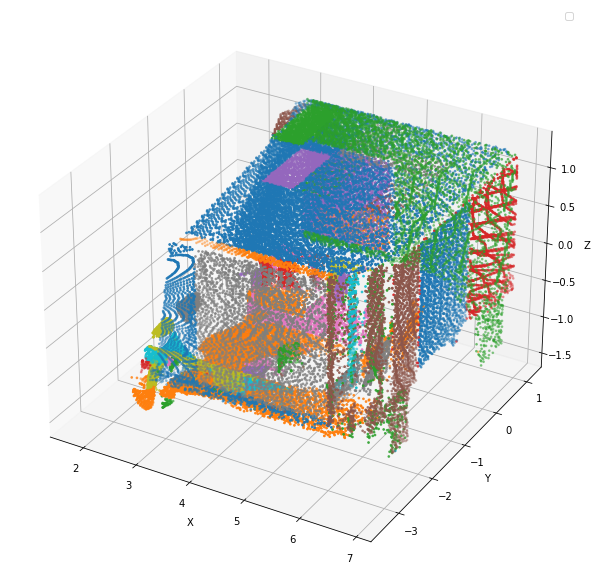

mask generation time:  0.8120591640472412
time: 1.1506907939910889
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54.]), array([ 9723, 10769,  6155,    83,  3893,  1788,  1997,  3583,  3140,
        1381,  1984,   744,  1067,  1640,  1144,  1261,  1832,   953,
        1065,   592,   456,   543,   151,   505,   371,   107,   405,
         271,   404,   224,   272,   324,   180,    68,   317,   118,
          56,   201,    50,    87,   947,  1042,   369,   423,   829,
         160,    43,   776,   683,   415,  1628,   537,    50,    44]))


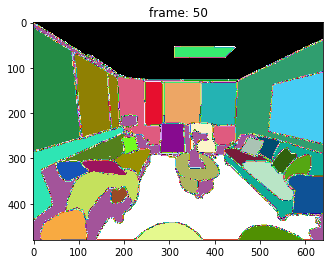

No handles with labels found to put in legend.


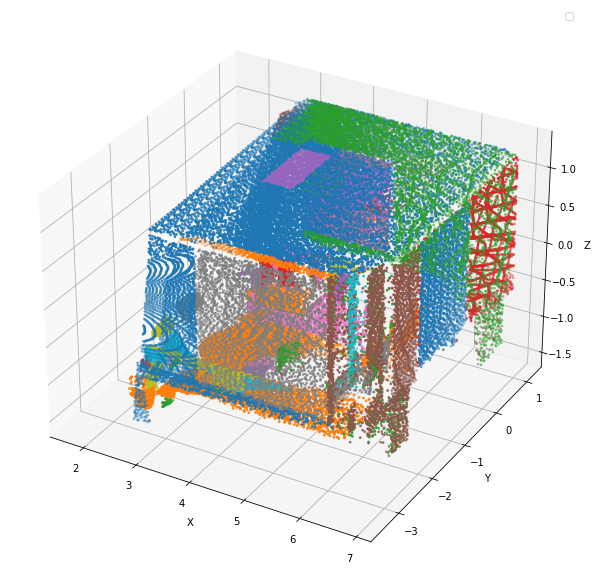

mask generation time:  0.7908225059509277
time: 1.1638357639312744
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55.]), array([11988, 12438,  6872,    83,  4398,  1835,  2244,  4070,  3465,
        1464,  2266,   744,  1297,  1942,  1260,  1404,  2071,  1086,
        1215,   664,   456,   644,   151,   579,   371,   107,   482,
         271,   474,   224,   272,   420,   180,    68,   375,   118,
          56,   201,    50,    87,  1356,  1259,   369,   520,  1053,
         160,    43,   776,   765,   497,  2657,   740,   108,    44,
          40]))


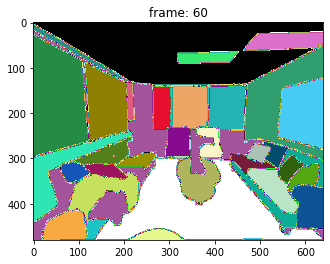

No handles with labels found to put in legend.


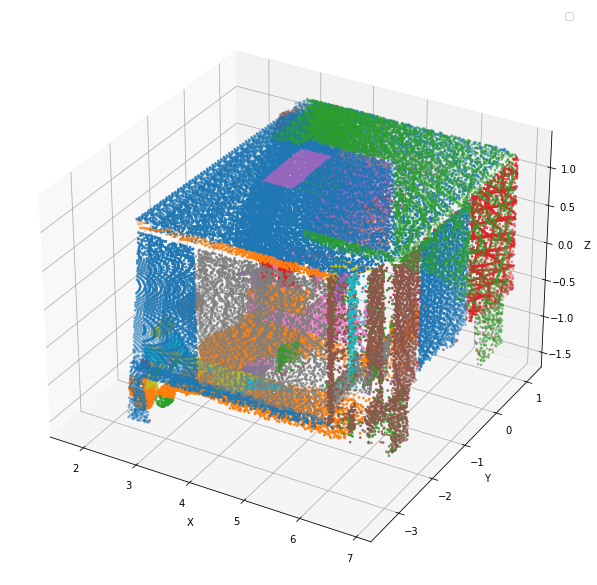

mask generation time:  0.7899374961853027
time: 1.1654558181762695
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56.]), array([14142, 14080,  7690,    83,  4792,  2131,  2523,  4595,  3823,
        1553,  2568,   744,  1549,  2277,  1399,  1549,  2131,  1226,
        1470,   742,   456,   786,   151,   672,   412,   107,   574,
         271,   558,   224,   272,   514,   180,    68,   443,   118,
          56,   243,    50,    87,  1710,  1533,   410,   606,  1212,
         160,    43,   776,   765,   497,  3701,   942,   108,    44,
          40,    43]))


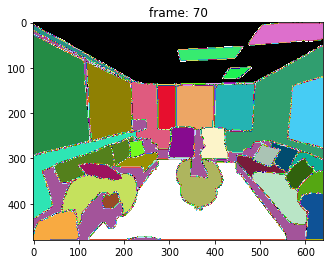

No handles with labels found to put in legend.


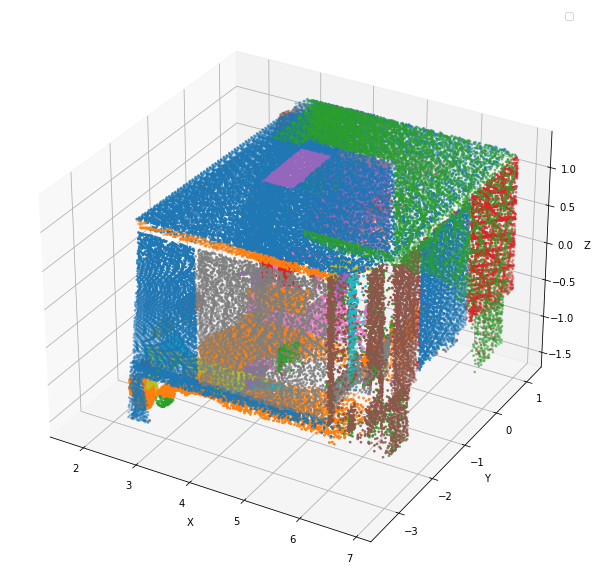

mask generation time:  0.803518533706665
time: 1.207200050354004
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57.]), array([15940, 16026,  8564,    83,  5097,  2628,  2842,  5238,  4254,
        1659,  2908,   744,  1549,  2666,  1604,  1707,  2175,  1375,
        1785,   935,   456,   949,   151,   794,   458,   107,   682,
         271,   662,   224,   272,   602,   180,    68,   525,   118,
          56,   302,    50,    87,  1710,  1891,   459,   665,  1300,
         160,    43,   776,   765,   497,  4596,  1111,   180,    44,
          40,    43,   102]))


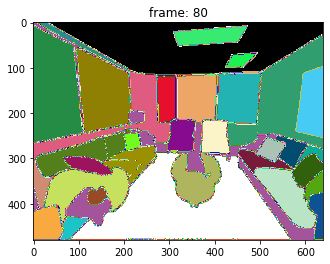

No handles with labels found to put in legend.


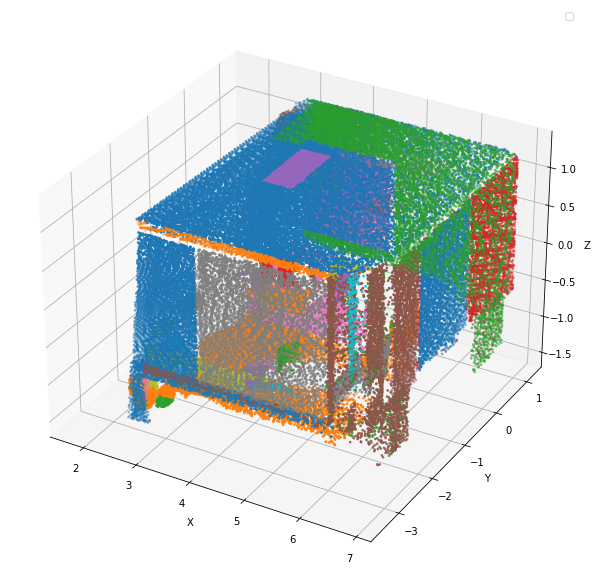

mask generation time:  0.806232213973999
time: 1.2150049209594727
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57.]), array([17191, 18447,  9485,    83,  5378,  2986,  3171,  6744,  4715,
        1774,  3284,   744,  1549,  3105,  1604,  1880,  2471,  1502,
        2094,  1099,   456,  1122,   151,   918,   508,   107,   796,
         271,   772,   224,   272,   602,   180,    68,   613,   118,
          56,   380,    50,    87,  1872,  2265,   510,   748,  1495,
         160,   193,   776,   868,   497,  4596,  1214,   278,    44,
          40,    43,   102]))


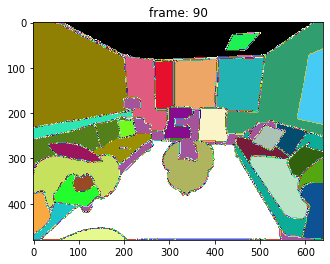

No handles with labels found to put in legend.


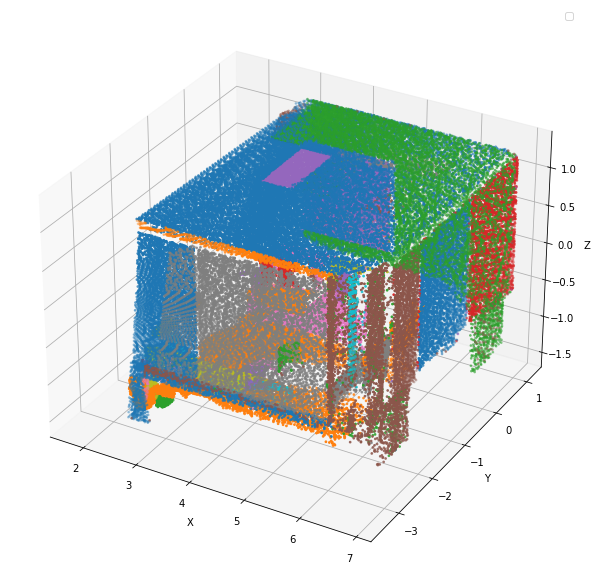

mask generation time:  0.8458623886108398
time: 1.3722150325775146
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57.]), array([18024, 20952, 10334,    83,  5725,  3343,  3453,  8195,  5084,
        1865,  3666,   744,  1549,  3567,  1604,  2051,  2733,  1610,
        2386,  1242,   456,  1289,   151,  1016,   555,   107,   891,
         271,   860,   224,   317,   602,   180,    68,   692,   118,
          56,   380,    50,    87,  2023,  2541,   550,   908,  1937,
         160,   193,   910,  1382,   497,  4596,  1346,   366,    44,
          40,    43,   102]))


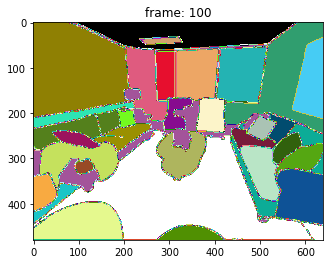

No handles with labels found to put in legend.


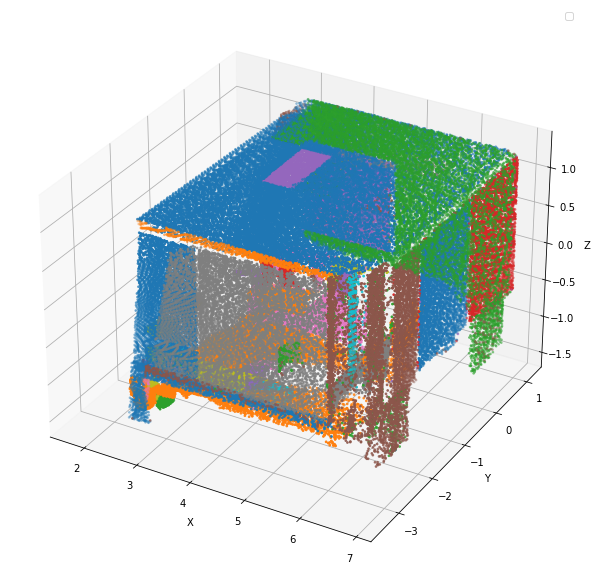

mask generation time:  0.8095815181732178
time: 1.4030985832214355
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57.]), array([19053, 23018, 11137,    83,  6067,  3343,  3679,  8790,  5348,
        1930,  4023,   744,  1549,  4026,  1604,  2205,  3087,  1610,
        2611,  1334,   456,  1448,   151,  1088,   555,   107,   963,
         271,   860,   224,   317,   602,   180,    68,   763,   118,
          56,   448,    50,    87,  2324,  2752,   550,  1041,  2472,
         160,   193,  1216,  2026,   497,  5532,  1520,   511,    44,
          40,    43,   102]))


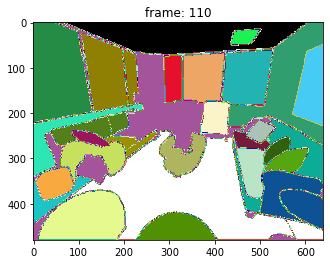

No handles with labels found to put in legend.


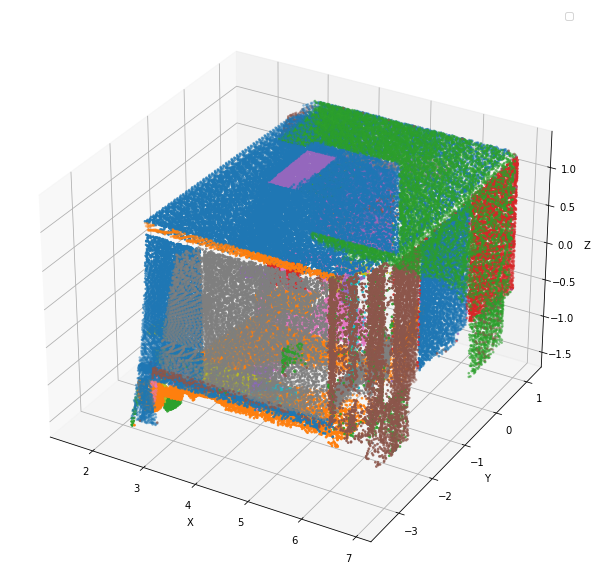

mask generation time:  0.7879302501678467
time: 1.44520902633667
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57.]), array([20731, 24795, 11894,    83,  6258,  3632,  3921,  9299,  5580,
        1987,  4367,   744,  1549,  4486,  1756,  2346,  3256,  1720,
        2811,  1453,   456,  1610,   151,  1170,   555,   107,  1053,
         271,   941,   224,   317,   602,   180,    68,   839,   118,
          56,   504,    50,    87,  2771,  2972,   550,  1188,  2927,
         160,   193,  1269,  2414,   497,  6711,  1668,   769,    44,
          40,    43,   102]))


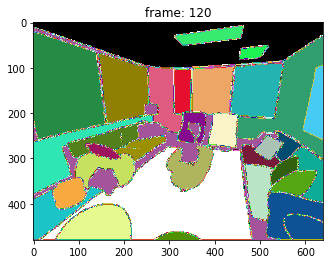

No handles with labels found to put in legend.


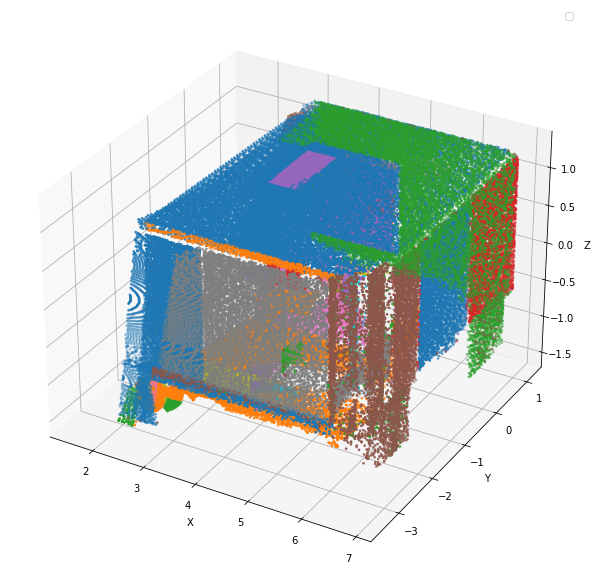

mask generation time:  0.7723562717437744
time: 1.2935113906860352
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57.]), array([23121, 26402, 12728,    83,  6258,  3632,  4233,  9827,  5855,
        2056,  4725,   744,  1549,  4973,  1900,  2492,  3318,  1836,
        3054,  1605,   456,  1791,   151,  1303,   555,   107,  1053,
         271,  1069,   224,   317,   602,   180,    68,   935,   118,
          56,   557,    50,    87,  3236,  3434,   550,  1343,  2986,
         160,   193,  1269,  2414,   497,  7938,  1855,   769,    44,
          40,    43,   102]))


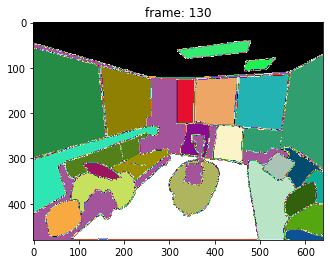

No handles with labels found to put in legend.


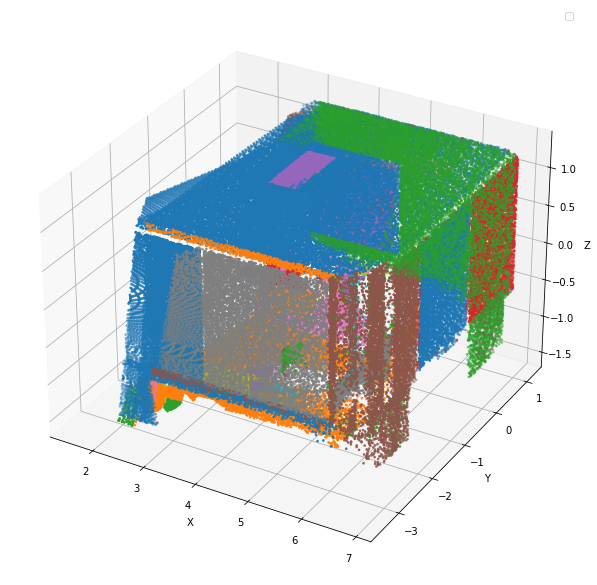

mask generation time:  0.7802431583404541
time: 1.3194801807403564
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57.]), array([25723, 27629, 13659,    83,  6400,  3632,  4627, 10449,  6237,
        2153,  5095,   744,  1549,  5457,  2058,  2647,  3420,  1974,
        3391,  1810,   456,  1983,   151,  1478,   602,   107,  1053,
         271,  1220,   224,   317,   602,   180,    68,  1080,   118,
          56,   608,    50,    87,  3481,  3901,   550,  1426,  2986,
         160,   193,  1269,  2414,   497,  8870,  1957,   769,    44,
          40,    43,   102]))


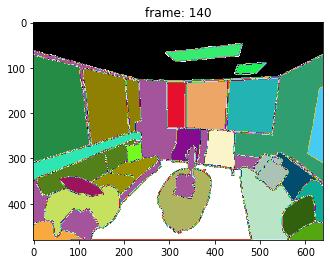

No handles with labels found to put in legend.


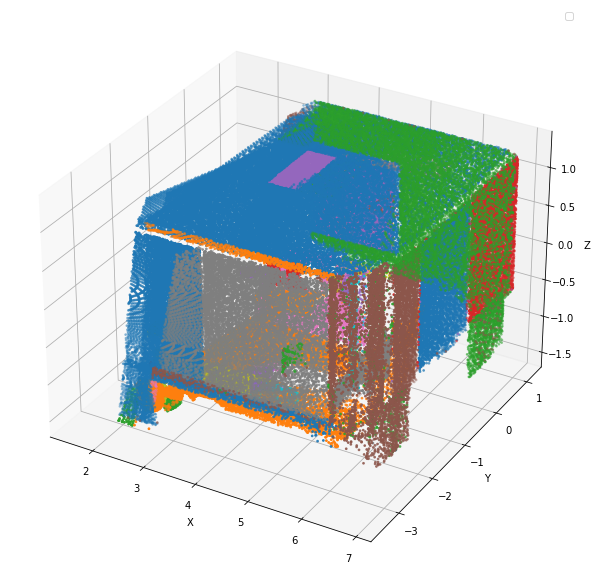

mask generation time:  0.7906656265258789
time: 1.3483247756958008
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57.]), array([28019, 28950, 14543,    83,  6852,  3632,  5040, 11292,  6573,
        2271,  5485,   744,  1549,  5924,  2254,  2807,  3709,  2101,
        3692,  2045,   456,  2170,   151,  1639,   655,   107,  1201,
         271,  1352,   224,   317,   602,   180,    68,  1177,   118,
          56,   608,    50,    87,  3481,  4197,   598,  1642,  2986,
         160,   193,  1269,  2414,   497,  9375,  1957,   769,    44,
          40,    43,   102]))


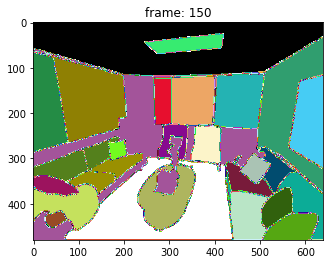

No handles with labels found to put in legend.


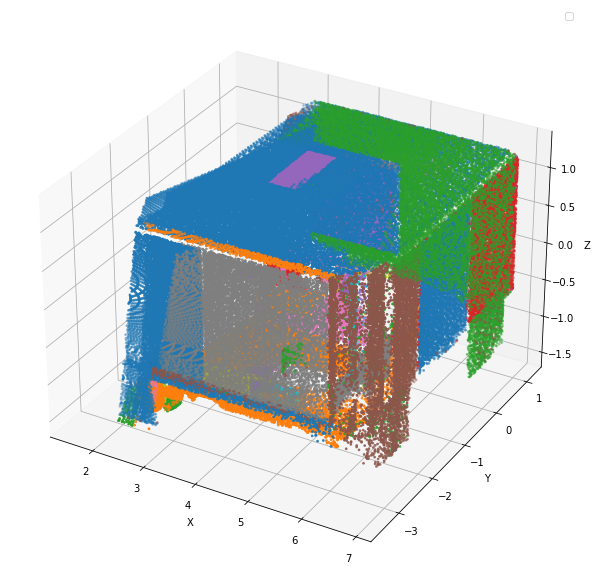

mask generation time:  0.7924072742462158
time: 1.4115519523620605
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57.]), array([29364, 30979, 15579,    83,  7267,  4160,  5407, 12222,  6855,
        2368,  5899,   744,  1549,  6526,  2254,  2979,  4145,  2259,
        3969,  2340,   456,  2365,   151,  1792,   708,   107,  1201,
         271,  1478,   224,   317,   602,   180,    68,  1276,   118,
          56,   694,    50,    87,  3481,  4536,   641,  1928,  3101,
         160,   193,  1269,  2414,   497,  9811,  1957,   769,    44,
          40,    43,   102]))


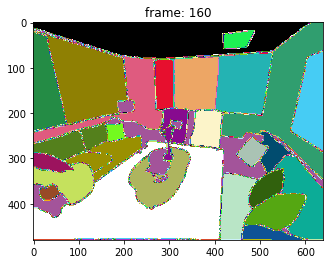

No handles with labels found to put in legend.


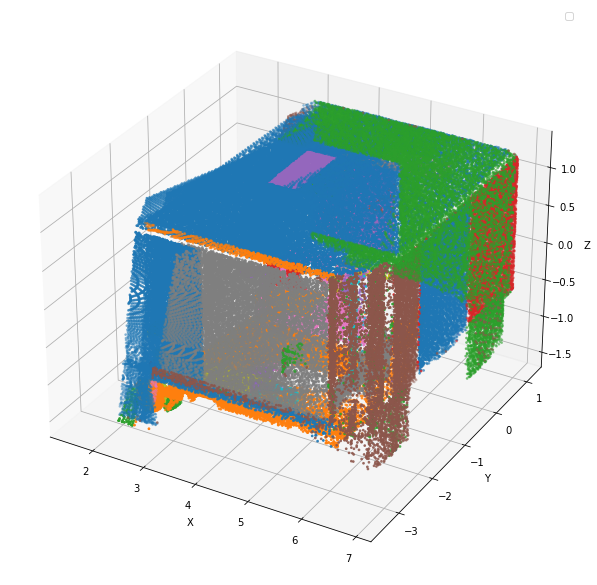

mask generation time:  0.7817158699035645
time: 1.2415127754211426
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57.]), array([29364, 33683, 16141,    83,  7267,  4160,  5782, 13757,  7183,
        2452,  6471,   744,  1549,  7400,  2254,  3194,  4288,  2404,
        4275,  2611,   456,  2611,   151,  1997,   759,   107,  1376,
         271,  1658,   224,   317,   602,   180,    68,  1455,   118,
          56,   694,    50,    87,  3674,  4986,   641,  2318,  3388,
         160,   193,  1269,  2616,   497,  9811,  2028,   769,    44,
          40,    43,   102]))


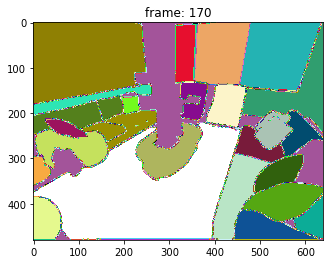

No handles with labels found to put in legend.


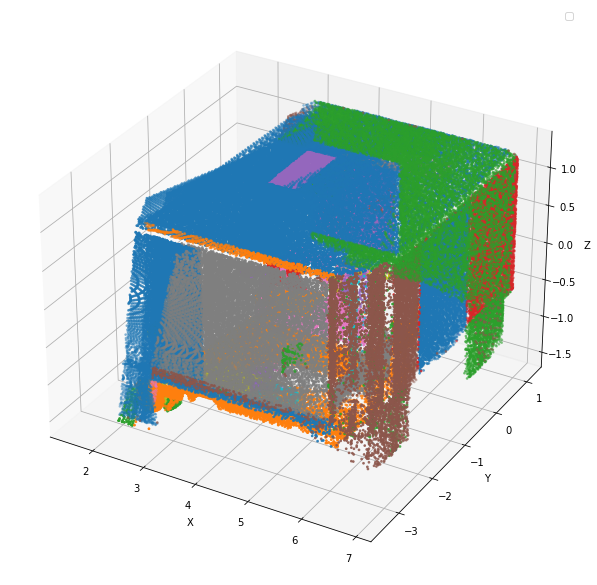

mask generation time:  0.7964279651641846
time: 1.2469398975372314
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57.]), array([29364, 36922, 16439,    83,  7267,  4160,  6217, 14298,  7475,
        2532,  6968,   744,  1549,  7787,  2254,  3351,  4288,  2696,
        4602,  2818,   456,  2969,   151,  2328,   816,   107,  1663,
         271,  1715,   224,   317,   602,   180,    68,  1736,   118,
          56,   694,    90,    87,  4360,  4986,   641,  2867,  3515,
         160,   193,  1377,  2898,   497, 10489,  2160,   838,    44,
          40,    43,   102]))


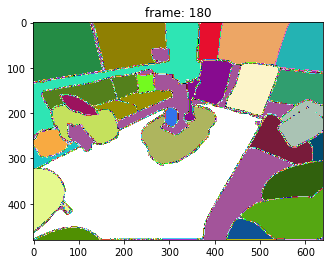

No handles with labels found to put in legend.


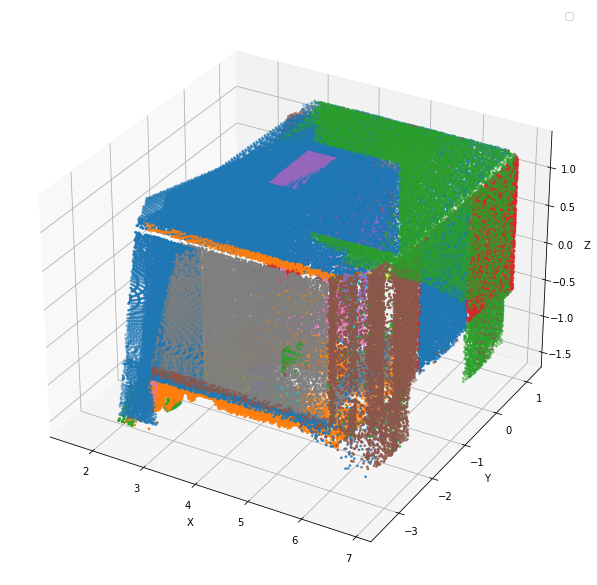

mask generation time:  0.7881851196289062
time: 1.182483434677124
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58.]), array([29364, 40316, 16759,    83,  7267,  4160,  6832, 15595,  7830,
        2633,  7539,   744,  1549,  8226,  2254,  3531,  4288,  2959,
        4956,  3167,   456,  3363,   151,  2834,   879,   107,  2080,
         271,  1715,   224,   317,   602,   220,    68,  2067,   118,
          56,   694,    90,    87,  4580,  5750,   641,  2867,  3515,
         160,   193,  1377,  2898,   497, 10489,  2214,   838,    44,
          40,    43,   102,    61]))


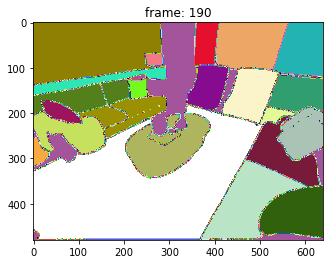

No handles with labels found to put in legend.


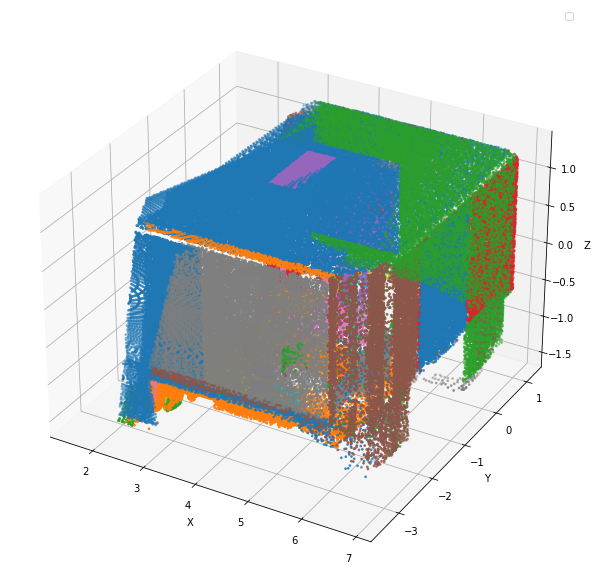

In [7]:
segmenter.runAuto()

In [ ]:
import numpy as np
import open3d as o3d
points = np.random.rand(10,3)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Step 2: Compute a mesh using the Ball Pivoting algorithm
# You may need to adjust the radii parameter based on the scale of your point cloud
radii = [0.005, 0.01, 0.02, 0.04]
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
       pcd, o3d.utility.DoubleVector(radii))

# Step 3: Simplify the mesh (optional, if you need to reduce the complexity)
mesh_simplified = mesh.simplify_quadric_decimation(target_number_of_triangles=1000)
o3d.io.write_triangle_mesh("test_mesh.obj", mesh_simplified)

In [ ]:
frame_reader.n_img//50

48

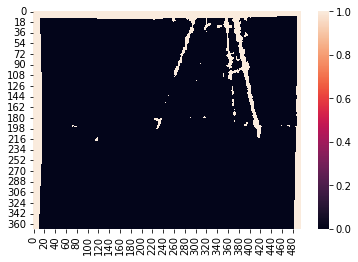

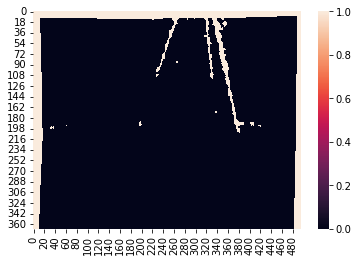

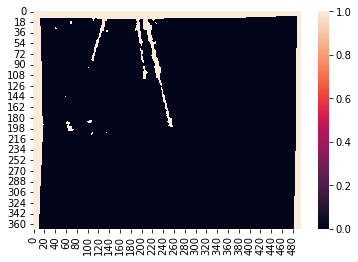

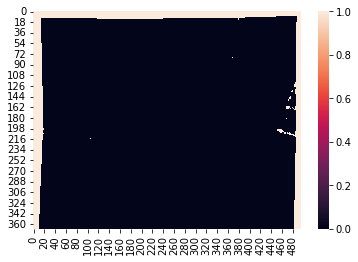

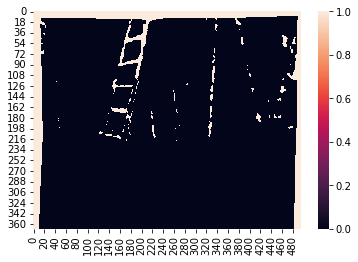

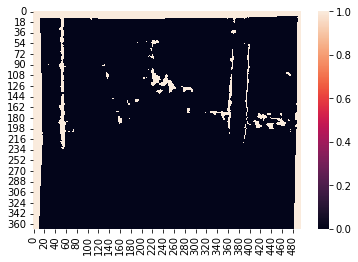

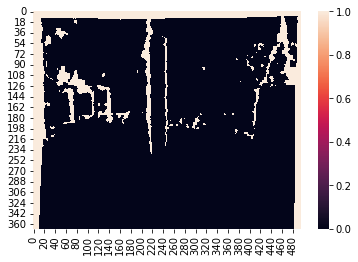

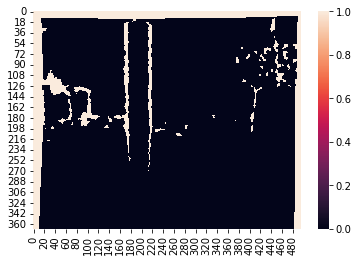

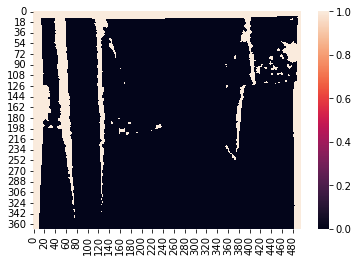

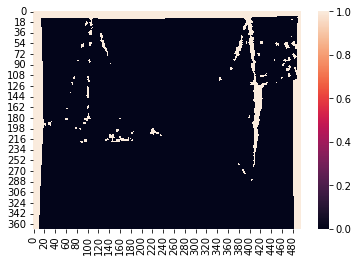

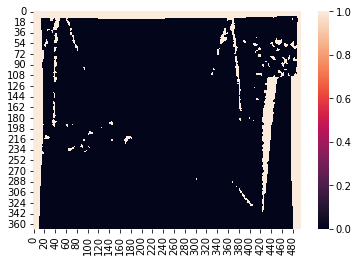

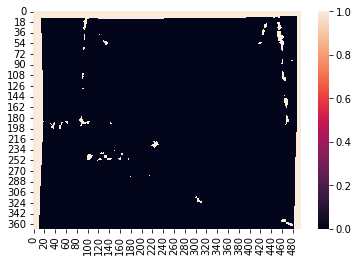

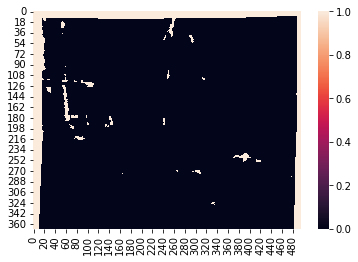

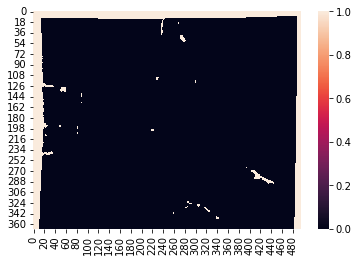

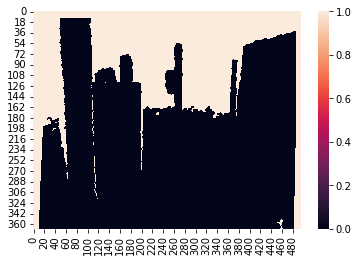

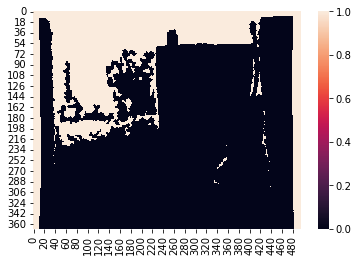

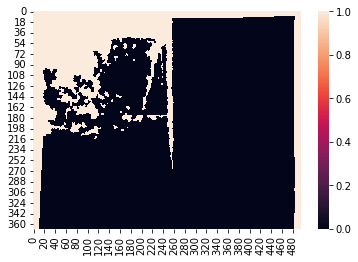

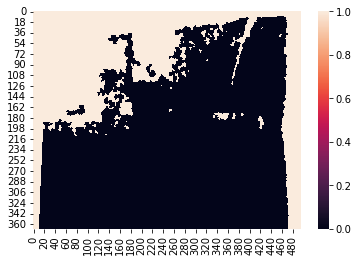

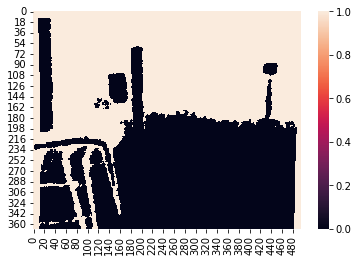

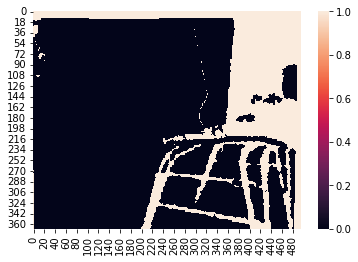

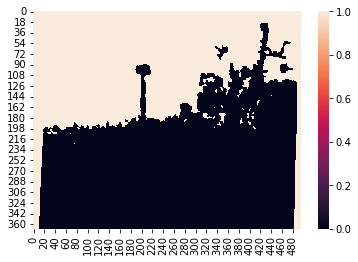

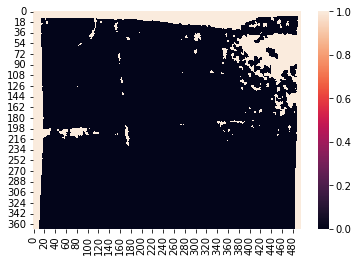

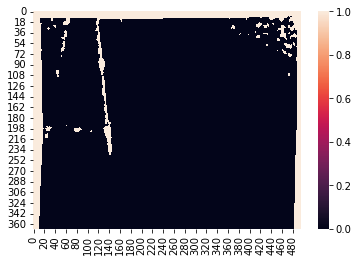

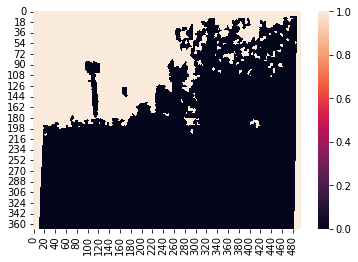

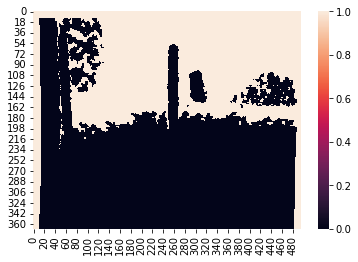

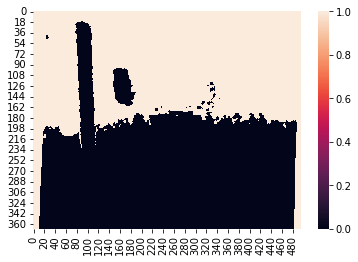

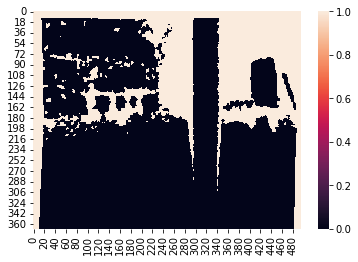

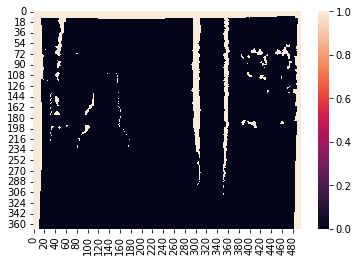

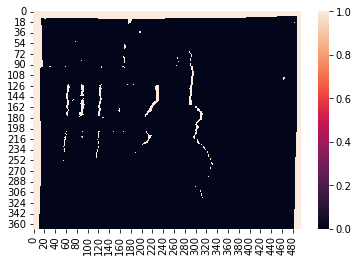

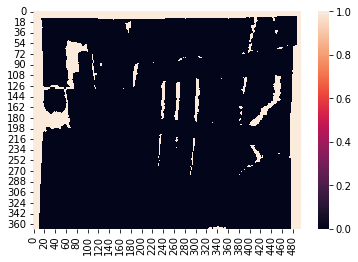

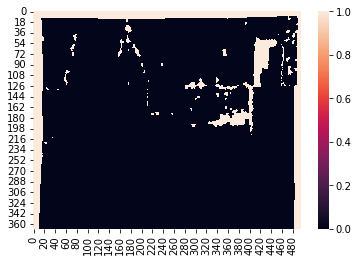

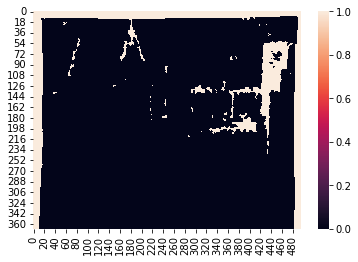

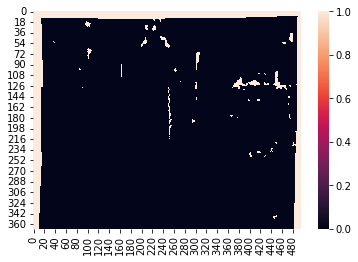

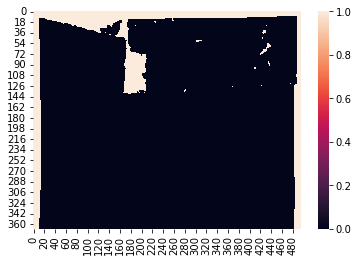

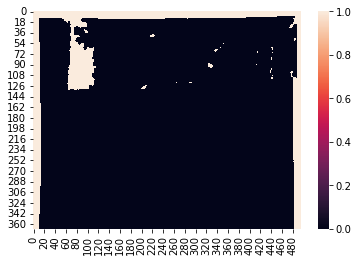

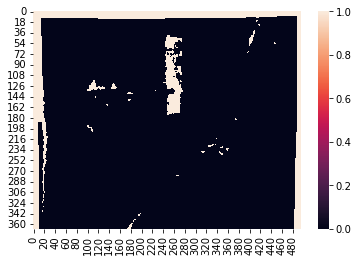

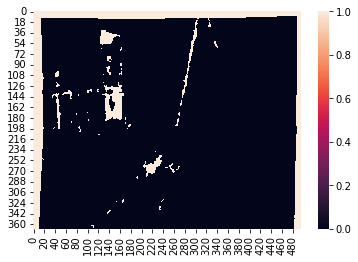

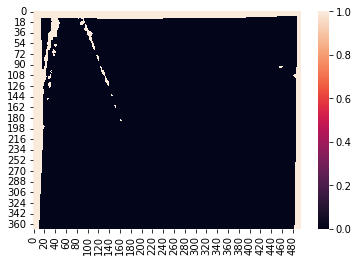

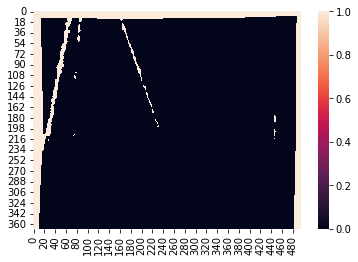

<Figure size 432x288 with 0 Axes>

In [ ]:
import seaborn as sns
for idx in range(0, frame_reader.n_img, 50):
    _,_, depth,_,_ = frame_reader[idx]
    sns.heatmap(depth.cpu().numpy() == 0)
    plt.show()
    plt.clf()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


depth shape: torch.Size([480, 640]), color shape: torch.Size([480, 640, 3])


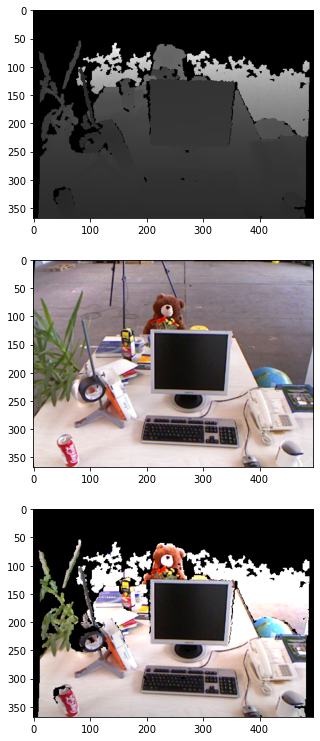

In [10]:
color, depth= frame_reader.get_colorAndDepth(1000)
#_,depth = frame_reader.get_colorAndDepth(80)
color = color.cpu().numpy()
depth = depth.cpu().numpy()
depth = depth / np.max(depth)
depth = np.stack([depth, depth, depth], axis=-1)
fig, ax = plt.subplots(3, 1, figsize=(40, 13))
ax[0].imshow(depth)
#plt.show()
ax[1].imshow(color)
#plt.show()
ax[2].imshow(color*depth*5)